In [1]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import numpy as np
import matplotlib.pyplot as plt

import archimedes as arc

from archimedes.sysid import pem, Timeseries
from archimedes.observers import ExtendedKalmanFilter
from archimedes import struct, discretize

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

np.random.seed(0)

# Part 2: Duffing Oscillator

In [Part 1](
../../generated/notebooks/sysid/sysid01) of this series we saw a simple workflow for estimating unknown model parameters from data in Archimedes using the example of a linear second-order system.

Next we'll use data from the more complex Duffing oscillator see how to:

* Create scalable model reperesentations using [PyTree](../../pytrees.md) data structures
* Impose physically-motivated bounds on the model parameters
* Handle unknown initial conditions
* Identify nonlinear dynamical system models (spoiler: it's the same as linear models)

In [2]:
alpha_true = 1.0    # linear stiffness
beta_true = 5.0     # nonlinear stiffness  
delta_true = 0.02   # damping
params_true = {"alpha": alpha_true, "beta": beta_true, "delta": delta_true}

# Fixed forcing parameters (known)
gamma = 8.0  # forcing amplitude
omega = 0.5  # forcing frequency

# Time vector
t0, tf = 0.0, 20.0  # Longer simulation to capture rich dynamics
dt = 0.02           # Smaller timestep for nonlinear system
ts = np.arange(t0, tf, dt)

# Problem dimensions
nx = 2  # state dimension (x₁, x₂)
nu = 1  # input dimension (forcing term)
ny = 1  # output dimension (y = x₁)

# Input signal (sinusoidal forcing)
us = gamma * np.cos(omega * ts).reshape(nu, -1)

# Initial conditions (start with some displacement and velocity)
x0_true = np.array([1.0, 0.5])  # non-zero initial conditions

# Generate true system response
def duffing_ode(t, x, u, params):
    """Duffing oscillator: ẍ + δẋ + αx + βx³ = γcos(ωt)"""
    alpha = params["alpha"]
    beta = params["beta"] 
    delta = params["delta"]
    
    x1, x2 = x[0], x[1]
    u_val = u[0]  # forcing term γcos(ωt)
    
    x1_t = x2
    x2_t = -delta * x2 - alpha * x1 - beta * x1**3 + u_val
    
    return np.hstack([x1_t, x2_t])

def obs(t, x, u, params):
    return x[0]  # observe position only

def ode_rhs(t, x, params):
    u = np.interp(t, ts, us[0]).reshape((nu,))
    return duffing_ode(t, x, u, params)

# Generate reference data
xs_true = arc.odeint(
    ode_rhs,
    t_span=(t0, tf),
    x0=x0_true,
    args=(params_true,),
    t_eval=ts,
)


In [3]:
ys = arc.vmap(obs, in_axes=(0, 1, 1, None))(ts, xs_true, us, params_true)
ys = np.atleast_2d(ys)

# Add measurement noise
noise_std = 0.01
ys = ys + np.random.normal(0, noise_std, ys.shape)

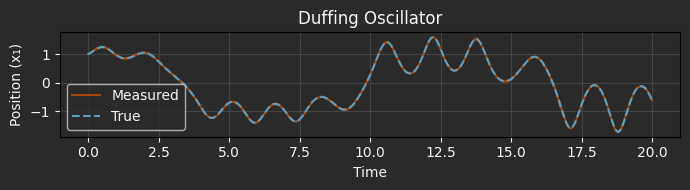

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 2), sharex=True)

# State trajectory
ax.plot(ts, ys[0], label="Measured", alpha=0.7)
ax.plot(ts, xs_true[0], label="True", linestyle='--')
ax.set_xlabel("Time")
ax.set_ylabel("Position (x₁)")
ax.legend()
ax.set_title("Duffing Oscillator")
ax.grid()
plt.tight_layout()
plt.show()

In [5]:

# Initial parameter guess (should be different from true values)
params_guess = {
    "alpha": 0.9,
    "beta": 4.9,
    "delta": 0.03,
}

R = noise_std ** 2 * np.eye(ny)  # Measurement noise covariance
Q = (0.01 * noise_std) ** 2 * np.eye(nx)  # Process noise covariance

# Set up PEM problem
dyn = discretize(duffing_ode, dt, method="rk4")
ekf = ExtendedKalmanFilter(dyn, obs, Q, R)
data = Timeseries(ts=ts, us=us, ys=ys)
options = {
    "ftol": 1e-6,
    "xtol": 1e-6,
    "gtol": 1e-6,
    "log_level": 10,
    "lambda0": 1e3,
}
result = pem(
    ekf,
    data,
    params_guess,
    x0=x0_true,  # Assume initial conditions are known
    method="lm",
    options=options,
)

# Validate results
print(f"\nDuffing Oscillator ID Results:")
print(f"True parameters: α={alpha_true:.3f}, β={beta_true:.3f}, δ={delta_true:.3f}")
print(f"Estimated parameters: α={result.x['alpha']:.3f}, β={result.x['beta']:.3f}, δ={result.x['delta']:.3f}")
print(f"Success: {result.success}")
print(f"Iterations: {result.nit}")



Duffing Oscillator ID Results:
True parameters: α=1.000, β=5.000, δ=0.020
Estimated parameters: α=0.976, β=4.992, δ=0.021
Success: True
Iterations: 16


In [6]:
# Validate forward simulation accuracy
xs_pred = arc.odeint(
    ode_rhs,
    t_span=(t0, tf),
    x0=x0_true,
    args=(result.x,),
    t_eval=ts,
)

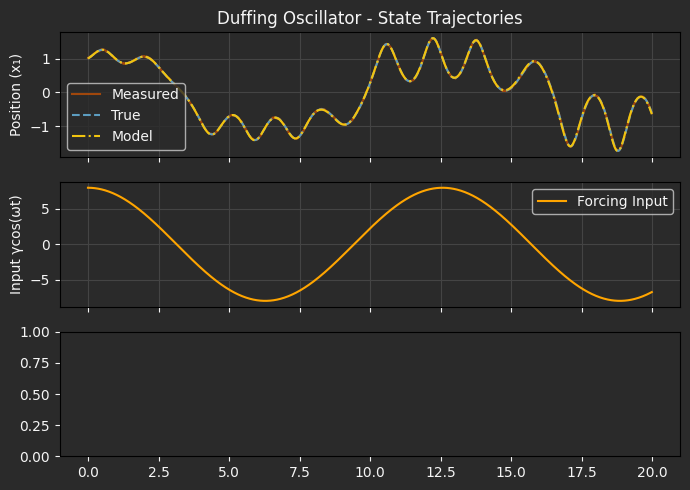

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

# State trajectory
ax[0].plot(ts, ys[0], label="Measured", alpha=0.7)
ax[0].plot(ts, xs_true[0], label="True", linestyle='--')
# ax[0].plot(ts, kf_result_init["x_hat"][0], label="Initial KF Estimate", linestyle=':')
ax[0].plot(ts, xs_pred[0], label="Model", linestyle='-.')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel("Position (x₁)")
ax[0].set_title("Duffing Oscillator - State Trajectories")

# Forcing input
ax[1].plot(ts, us[0], label="Forcing Input", c='orange')
ax[1].set_ylabel("Input γcos(ωt)")
ax[1].legend()
ax[1].grid()

# # Kalman residuals
# ax[2].plot(ts, kf_result_init["e"].T, label="Initial residuals", alpha=0.7)
# ax[2].plot(ts, kf_result_opt["e"].T, label="Final residuals", alpha=0.7)
# ax[2].set_ylabel("Kalman residuals")
# ax[2].legend()
# ax[2].grid()

plt.tight_layout()
plt.show()

In [8]:
# Unknown initial state

# Initial parameter guess (should be different from true values)
params_guess = {
    "alpha": 0.9,
    "beta": 4.9,
    "delta": 0.03,
}

R = noise_std ** 2 * np.eye(ny)  # Measurement noise covariance
Q = (0.01 * noise_std) ** 2 * np.eye(nx)  # Process noise covariance

# Set up PEM problem
dyn = discretize(duffing_ode, dt, method="rk4")
ekf = ExtendedKalmanFilter(dyn, obs, Q, R)
data = Timeseries(ts=ts, us=us, ys=ys)
options = {
    "ftol": 1e-6,
    "xtol": 1e-6,
    "gtol": 1e-6,
    "log_level": 10,
    "lambda0": 1e3,
}
x0_guess = np.array([0.0, 0.0])  # Initial guess for state
result = pem(
    ekf,
    data,
    (x0_guess, params_guess),
    method="lm",
    options=options,
)

x0_opt, params_opt = result.x

# Validate results
print(f"\nDuffing Oscillator ID Results:")
print(f"True parameters: α={alpha_true:.3f}, β={beta_true:.3f}, δ={delta_true:.3f}")
print(f"Estimated parameters: α={params_opt['alpha']:.3f}, β={params_opt['beta']:.3f}, δ={params_opt['delta']:.3f}")
print(f"True initial state: x₀={x0_true}")
print(f"Estimated initial state: x₀={x0_opt}")
print(f"Success: {result.success}")
print(f"Iterations: {result.nit}")



Duffing Oscillator ID Results:
True parameters: α=1.000, β=5.000, δ=0.020
Estimated parameters: α=0.976, β=4.992, δ=0.021
True initial state: x₀=[1.  0.5]
Estimated initial state: x₀=[1.011238   0.30168213]
Success: True
Iterations: 17


In [9]:
# Validate forward simulation accuracy
xs_pred = arc.odeint(
    ode_rhs,
    t_span=(t0, tf),
    x0=x0_opt,
    args=(params_opt,),
    t_eval=ts,
)

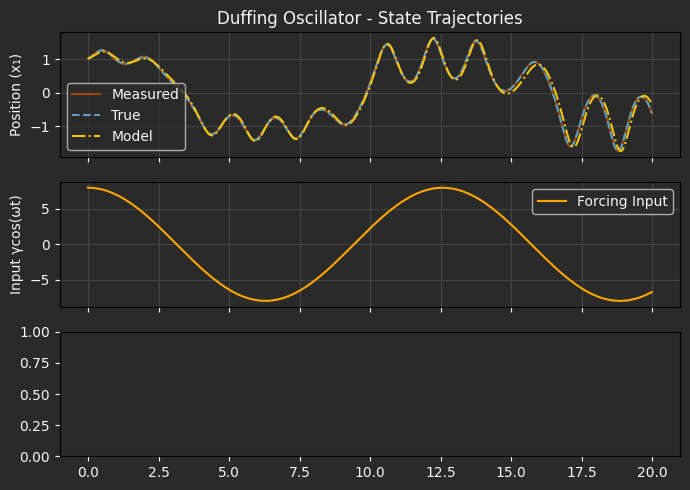

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

# State trajectory
ax[0].plot(ts, ys[0], label="Measured", alpha=0.7)
ax[0].plot(ts, xs_true[0], label="True", linestyle='--')
# ax[0].plot(ts, kf_result_init["x_hat"][0], label="Initial KF Estimate", linestyle=':')
ax[0].plot(ts, xs_pred[0], label="Model", linestyle='-.')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel("Position (x₁)")
ax[0].set_title("Duffing Oscillator - State Trajectories")

# Forcing input
ax[1].plot(ts, us[0], label="Forcing Input", c='orange')
ax[1].set_ylabel("Input γcos(ωt)")
ax[1].legend()
ax[1].grid()

# # Kalman residuals
# ax[2].plot(ts, kf_result_init["e"].T, label="Initial residuals", alpha=0.7)
# ax[2].plot(ts, kf_result_opt["e"].T, label="Final residuals", alpha=0.7)
# ax[2].set_ylabel("Kalman residuals")
# ax[2].legend()
# ax[2].grid()

plt.tight_layout()
plt.show()

## BFGS optimizer

In [ ]:
result = pem(
    ekf,
    data,
    params_guess,
    x0=x0_true,  # Assume initial conditions are known
    method="bfgs",
)

# Validate results
print(f"\nDuffing Oscillator ID Results (BFGS):")
print(f"True parameters: α={alpha_true:.3f}, β={beta_true:.3f}, δ={delta_true:.3f}")
print(f"Estimated parameters: α={result.x['alpha']:.3f}, β={result.x['beta']:.3f}, δ={result.x['delta']:.3f}")
print(f"Success: {result.success}")
print(f"Iterations: {result.nit}")
print(f"Final cost: {result.fun:.2e}")